In [1]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/VAE/model.py
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/results.py

--2024-02-13 09:14:48--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2810 (2.7K) [text/plain]
Saving to: ‘input_pipeline.py’

input_pipeline.py   100%[===================>]   2.74K  --.-KB/s    in 0s      

2024-02-13 09:14:49 (44.6 MB/s) - ‘input_pipeline.py’ saved [2810/2810]



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from pathlib import Path
import pandas as pd
import tensorflow as tf
import seaborn as sns
from model import VAE, sample
from results import plot_spins, calcEnergy, calcMag, make_gif, cost_function_plot

plt.rcParams['figure.dpi'] = 300

drive.mount('/content/drive', force_remount=True)
drive_path = Path("drive/MyDrive/Licencjat")

Mounted at /content/drive


# Training

In [4]:
def generate_and_save_images(model, epoch, test_sample, results):
  predictions = make_prediction(model, test_sample)
  plot_spins(results / "Images" / f'image_at_epoch_{epoch}.png', predictions, test_sample)

def make_prediction(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

def process_data(spin_image):
  df = pd.DataFrame({'image': list(spin_image)})
  df['Magnetization'] = df['image'].apply(calcMag)
  df['Energy'] = df['image'].apply(calcEnergy)
  df.drop(columns='image', inplace=True)
  return df

def sample_data_plots(model, test_size, batch_size, test_set, results):
  sample_data = []
  num = test_size
  for _ in range(batch_size):
    sample_data.append(sample(num, model))
  spin_sample = tf.concat(sample_data, axis = 0)
  preds = []
  reals = []
  for test_x in test_set:
    preds.append(make_prediction(model, test_x))
    reals.append(test_x)

  predicted_spin = np.concatenate(preds)
  real_spin = np.concatenate(reals)
  predicted_spin =  2 * np.random.binomial(1, predicted_spin) - 1
  real_spin =  2 * real_spin - 1
  spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
  df = get_statistics_df(predicted_spin, real_spin, spin_sample)
  sns.displot(df, x = 'Magnetization', kind ='kde', hue='Algorithm')
  plt.savefig(results / f"mag.png")
  sns.displot(df, x = 'Energy', kind ='kde', hue='Algorithm')
  plt.savefig(results / f"energy.png")

def get_statistics_df(perdicted_spin, real_spin, spin_sample):
  df_model = process_data(perdicted_spin)
  df_model['Algorithm'] = 'VAE testset'

  df_test = process_data(real_spin)
  df_test['Algorithm'] = 'Wolff testset'

  df_sample = process_data(spin_sample)
  df_sample ['Algorithm'] = 'VAE sample'

  df = pd.concat([df_model, df_test, df_sample])
  return df

In [5]:
def load_starting_weights(model):
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(drive_path / "Results" / "reference" / "vae2.2.h5")

# Dataset

In [6]:
from IPython import display
from time import time
from input_pipeline import dataset_tfrecord_pipeline
from model import VAE, compute_loss, train_step, sample

def train_at_t(temp, model, batch_size = 100, epochs = 50, latent_dim = 200, num_examples_to_generate = 5, test_size = 100):
  # Folders for storing the results and dataset
  trainset_path = drive_path / "data" /  f"Data{temp}.tfrecord"

  results = drive_path / "Results" / str(temp)
  results.mkdir(exist_ok = True )

  images = results / "Images"
  images.mkdir(exist_ok = True)

  train_set = dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
  test_set = train_set.take(test_size)
  loss_monitor = 3 * [False]

  # Test sample for image generation
  assert batch_size >= num_examples_to_generate
  for test_batch in test_set.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  generate_and_save_images(model, 0, test_sample, results)

  # Training loop
  loss_list = []
  for epoch in range(1, epochs + 1):
    time_start = time()
    for train_x in train_set:
      train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for test_x in test_set:
      loss(compute_loss(model, test_x))

    elbo = -loss.result()
    loss_list.append(loss.result().numpy())

    # Early stopping for VAE
    if epoch > 1:
      loss_monitor.pop(-1)
      loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
      if all(loss_monitor):
        print("STOP!")
        break

    # Spins from testset
    display.clear_output(wait=False)
    generate_and_save_images(model, epoch, test_sample, results)
    elapsed = time() - time_start
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')

  # Results
  make_gif(results, temp)
  cost_function_plot(loss_list, results)
  sample_data_plots(model, test_size, batch_size, test_set, results)
  model.save_weights(results / f'vae{temp}.h5',save_format='h5')


In [7]:
temps = [2.6, 2.7, 2.8, 2.9]
model = VAE(200, lattice_size = 32)
optimizer = tf.keras.optimizers.Adam(1e-4)

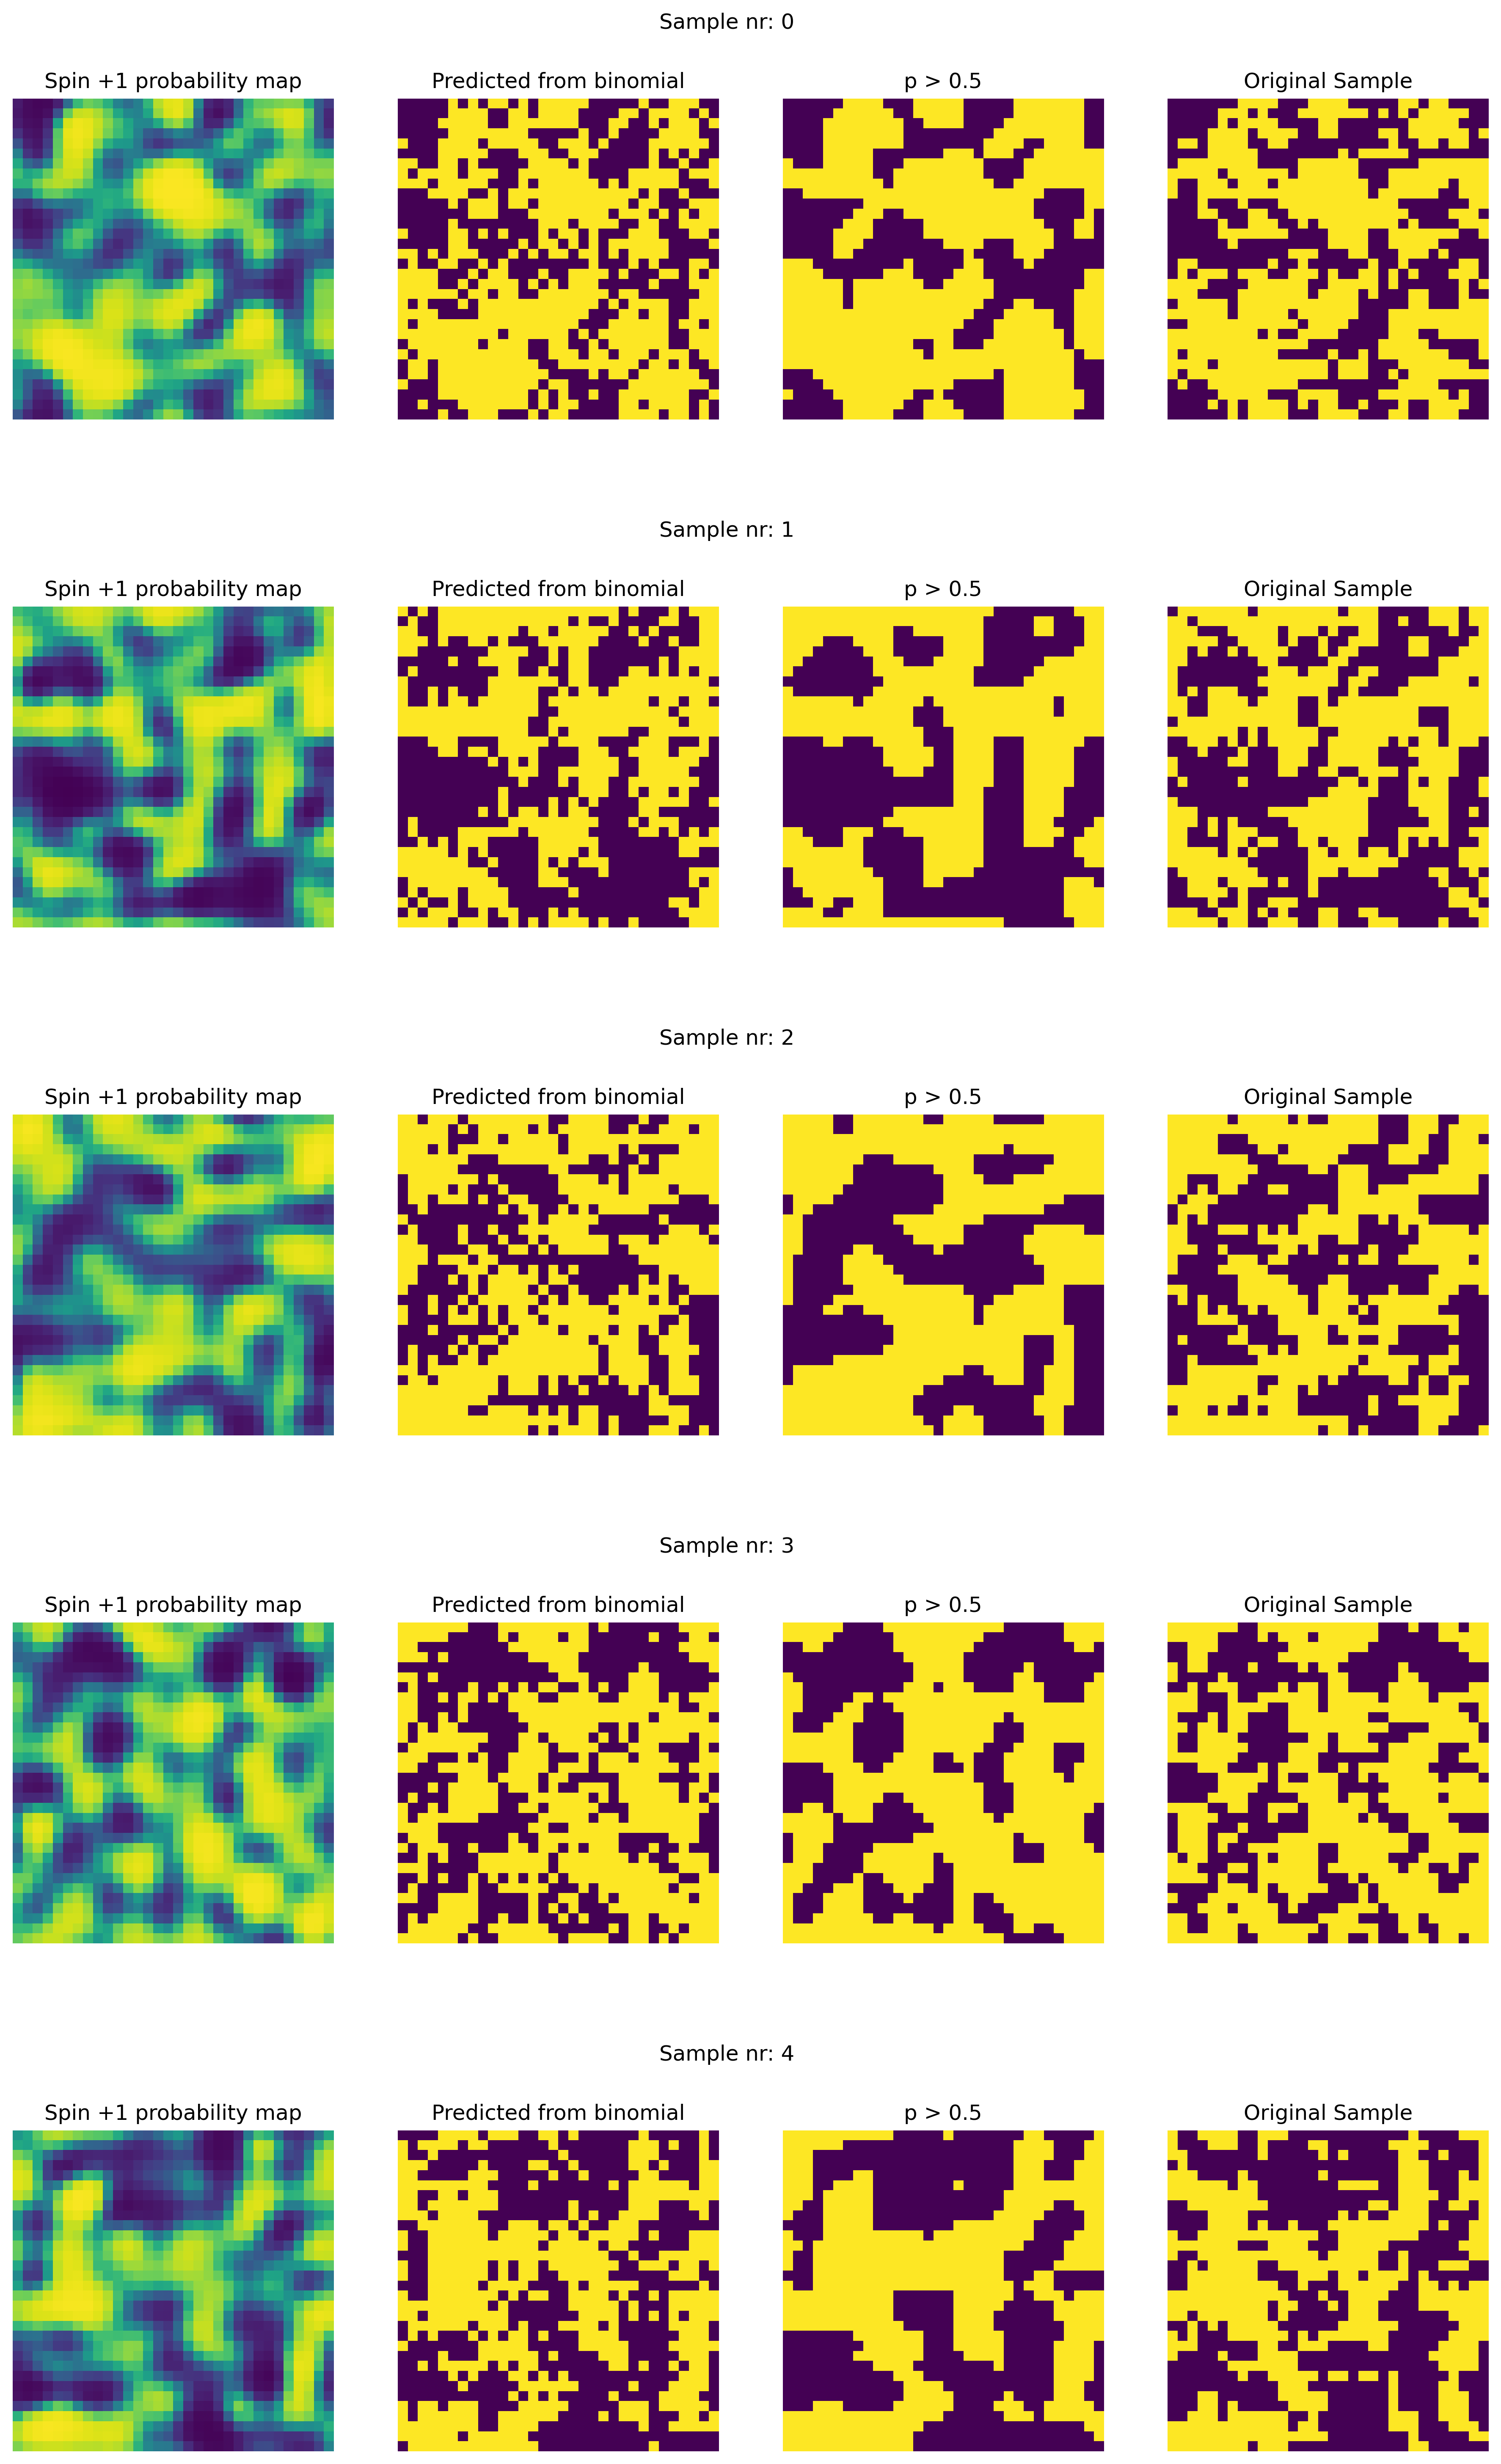

Epoch: 50, Test set ELBO: -577.6275634765625, Time needed: 15.417603492736816


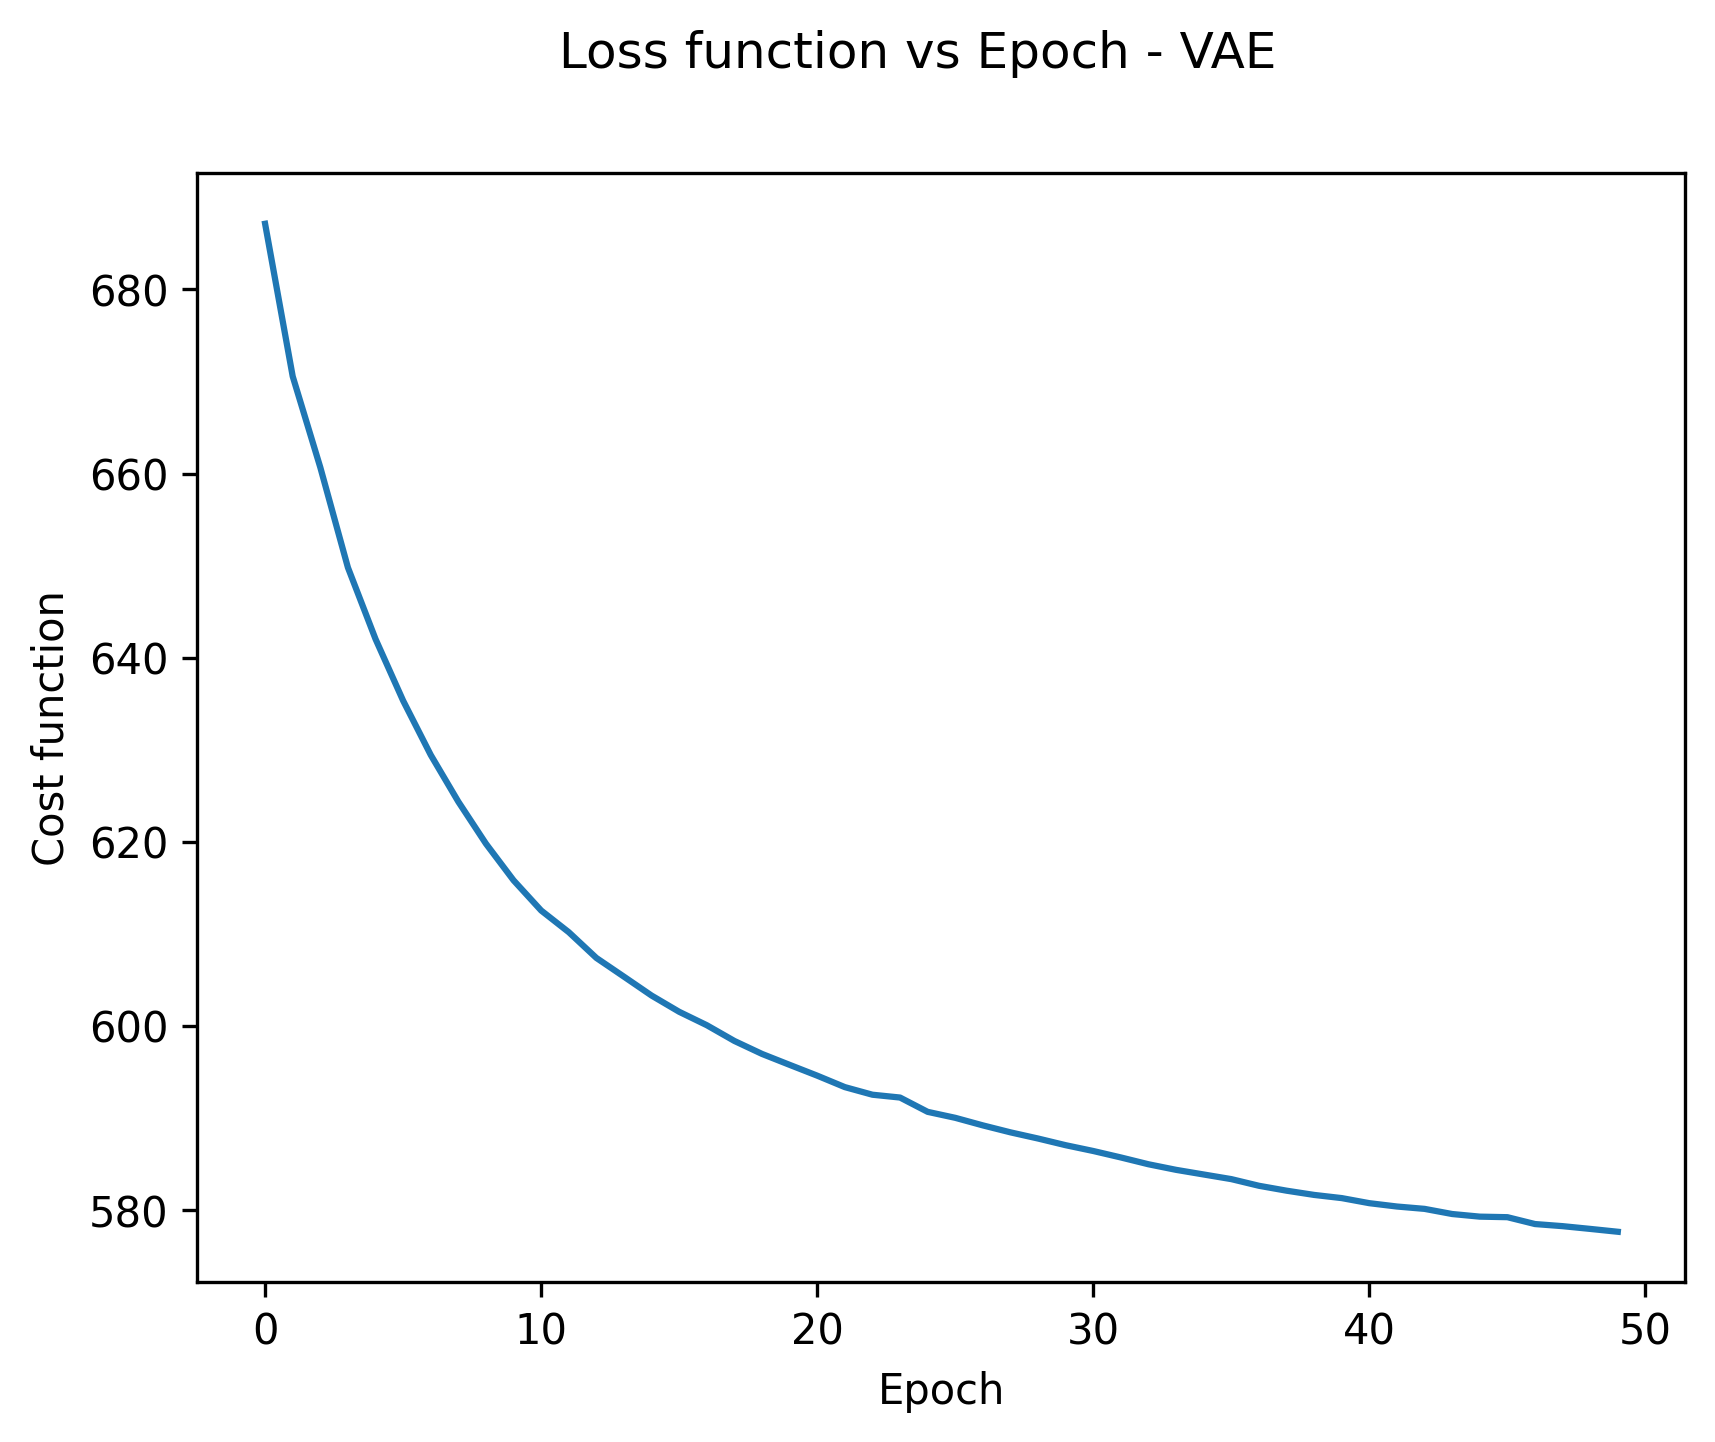

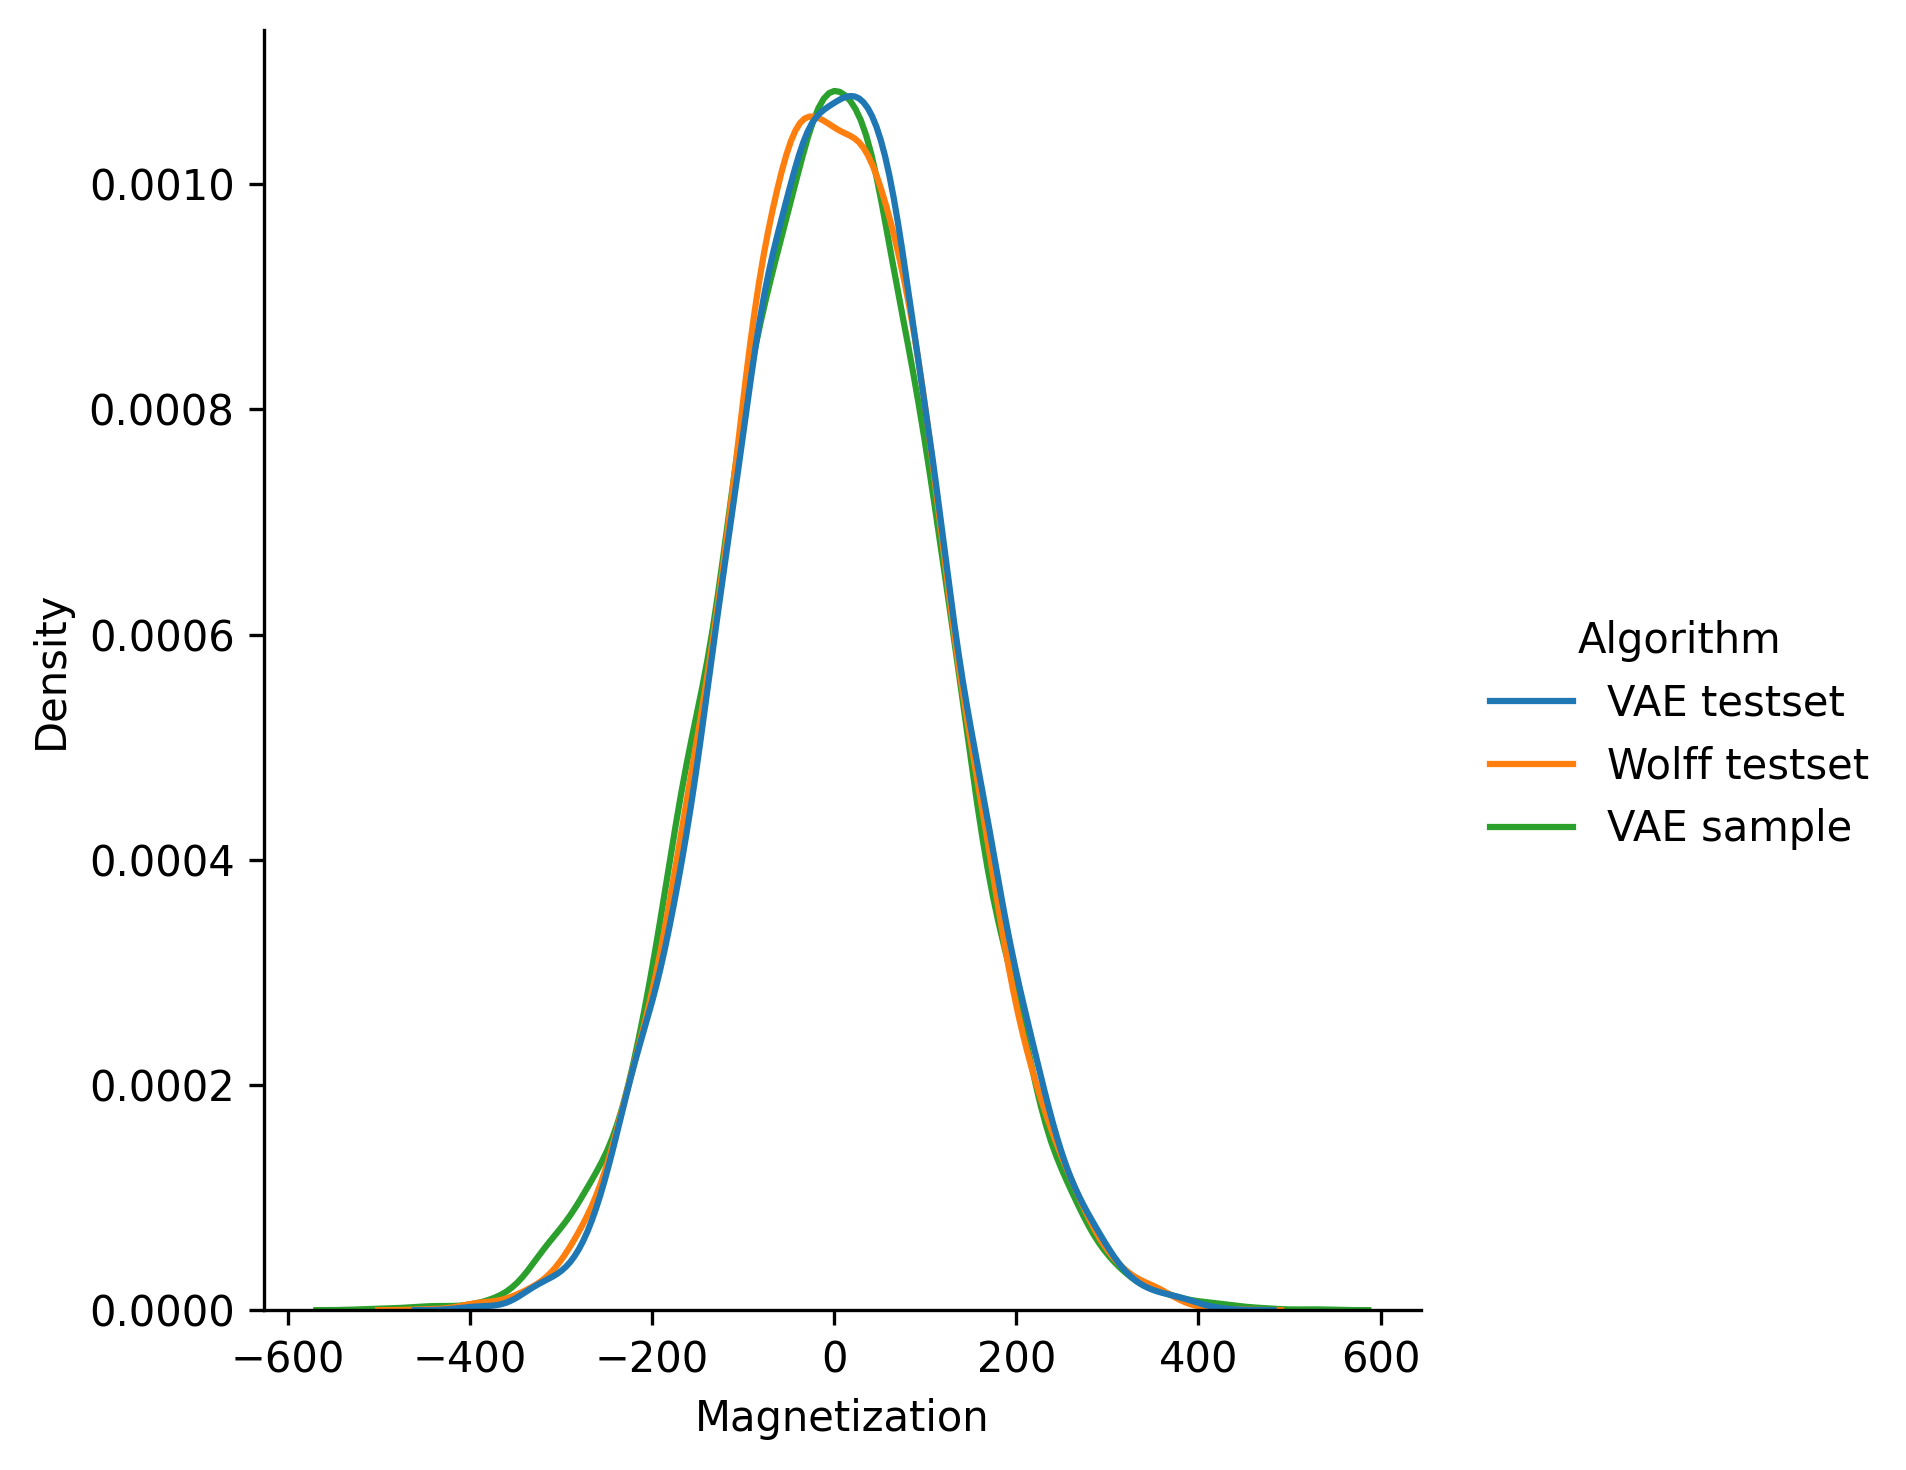

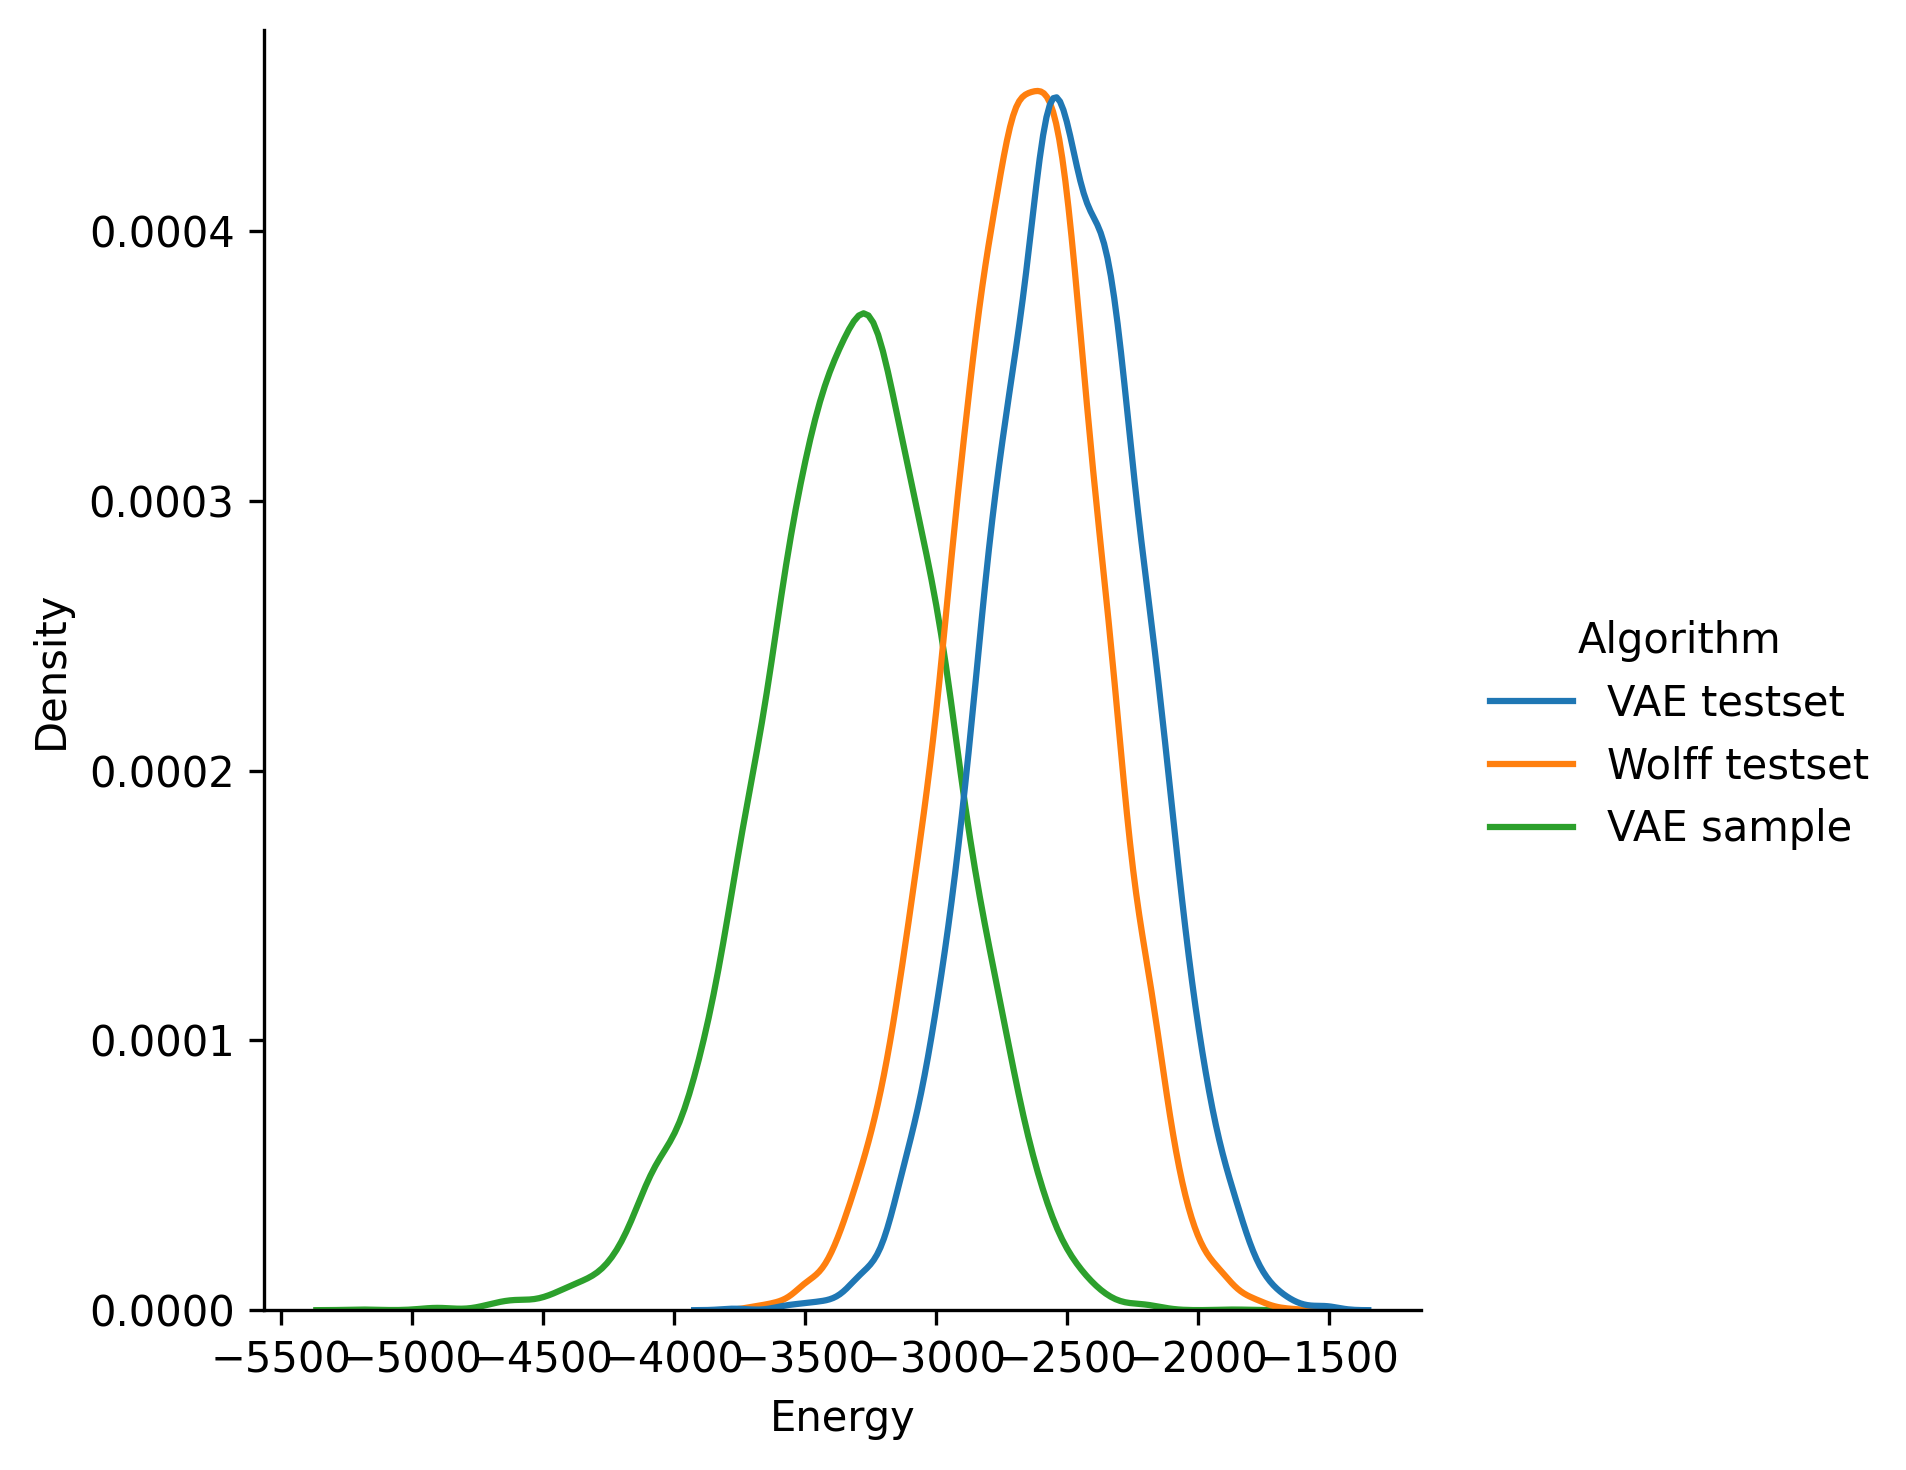

In [8]:
epochs = 50
latent_dim = 200
num_examples_to_generate = 5
batch_size = 100

for i, temp in enumerate(temps):
  load_starting_weights(model)
  train_at_t(temp, model, batch_size, epochs, latent_dim, num_examples_to_generate)